# MNIST Training using PyTorch

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)

---

## Background

MNIST는 손으로 쓴 숫자 분류에 널리 사용되는 데이터 세트입니다.이 이미지는 손으로 쓴 숫자로 표시된 70,000개의 28x28 픽셀 그레이스케일 이미지로 구성되어 있습니다.이 데이터셋은 60,000개의 훈련 이미지와 10,000개의 테스트 이미지로 분할됩니다. 10개의 클래스가 존재하고 (10자리 숫자당 하나씩) 이 예제에서는 PyTorch를 사용하여 SageMaker에서 MNIST 모델을 학습시키고 테스트하는 방법을 보여줍니다.

SageMaker 의 PyTorch 에 대한 더 자세한 정보는 다음 링크와 github 리포지토리에서 확인할 수 있습니다. [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) 

---

## Setup

_이 노트북은 ml.m4.xlarge 노트북 인스턴스에서 제작 및 테스트되었습니다._

먼저 SageMaker 세션을 생성하고 다음을 지정해 보겠습니다.

- 학습 및 모델 데이터에 사용할 S3 버킷 및 디렉토리 구조, 노트북 인스턴스는 학습 및 호스팅과 동일한 리전 내에 있어야 합니다.
- 데이터에 대한 학습 및 호스팅 액세스 권한을 부여하는 데 사용되는 IAM 역할 arn입니다. 자세한 생성 방법은 설명서를 참조하십시오. 노트북 인스턴스, 학습 및/또는 호스팅에 둘 이상의 역할이 필요한 경우 `sagemaker.get_execution_role () `을 적절한 전체 IAM 역할 arn 문자열로 바꾸십시오.


In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()

#TODO: default 버킷을 사용할 수 도 있고 사용자 지정 버킷을 사용할 수 있습니다. 사용자 지정 버킷을 사용하도록 합니다. 
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-mnist'

role = sagemaker.get_execution_role()

## Data
### Getting the data



In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms

MNIST.mirrors = ["https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/"]

MNIST(
    'data',
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )
)

100.1%

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


16.4%%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


180.4%/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370116979/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

### Uploading the data to S3
`SageMaker.session.upload_data` 함수를 사용하여 데이터 세트를 S3 위치에 업로드할 예정입니다. 반환 값 입력은 위치를 식별합니다. 나중에 학습 작업을 시작할 때 사용합니다.


In [4]:
inputs = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix=prefix)
print('input spec (in this case, just an S3 path): {}'.format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-ap-northeast-2-806174985048/sagemaker/DEMO-pytorch-mnist


## Train
### Training script
`mnist.py` 스크립트는 SageMaker 모델 (모델을 로드하기 위한 `model_fn` 함수) 을 훈련시키고 호스팅하는 데 필요한 모든 코드를 제공합니다.
학습 스크립트는 SageMaker 외부에서 실행할 수 있는 교육 스크립트와 매우 유사하지만 다음과 같은 다양한 환경 변수를 통해 교육 환경에 대한 유용한 속성에 액세스할 수 있습니다.

* `SM_MODEL_DIR`: 모델 아티팩트를 쓸 디렉터리의 경로를 나타내는 문자열입니다. 이 아티팩트는 모델 호스팅을 위해 S3에 업로드됩니다.
* `SM_NUM_GPUS`: 현재 컨테이너에서 사용할 수 있는 GPU의 개수입니다.
* `SM_CURRENT_HOST`: 컨테이너 네트워크에서 현재 컨테이너의 이름.
* `SM_HOSTS`: 모든 호스트를 포함하는 JSON으로 인코딩된 목록입니다.

파이토치 Estimator 의 `fit ()` 메서드 호출에 하나의 입력 채널 'train' 이 사용되었다고 가정하면, `SM_CHANNEL_ [channel_name]` 형식에 따라 다음과 같이 설정됩니다.

* `SM_CHANNEL_TRAINING`: 'training' 채널의 데이터가 들어 있는 디렉터리의 경로를 나타내는 문자열입니다.

학습 환경 변수에 대한 자세한 내용은 [SageMaker 컨테이너] (https://github.com/aws/sagemaker-containers) 를 참조하십시오.

일반적인 학습 스크립트는 입력 채널에서 데이터를 로드하고, 하이퍼파라미터를 사용하여 훈련을 구성하고, 모델을 학습시키고, 모델을 `model_dir'에 저장하여 나중에 호스팅할 수 있도록 합니다. 하이퍼파라미터는 스크립트에 parameter 로 전달되며 `argparse.argumentParser` 인스턴스를 사용하여 검색할 수 있습니다.

SageMaker는 학습 스크립트를 가져오므로, 이 예제와 동일한 스크립트를 사용하여 모델을 호스팅하는 경우 SageMaker가 실수로 잘못된 실행 지점에서 학습 코드를 실행하지 않도록 주 (``if __name__='__main__': ``) 에 훈련 코드를 넣어야 합니다.

예를 들어, 이 노트북에서 실행되는 스크립트는 다음과 같습니다.

In [5]:
!pygmentize mnist.py

import argparse
import json
import logging
import os
import sys

#import sagemaker_containers
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 32

### Run training in SageMaker

'PyTorch' 클래스를 사용하면 SageMaker 인프라에서 학습 작업으로 training 기능을 실행할 수 있습니다. 학습 스크립트, IAM 역할, 학습 인스턴스 수, 학습 인스턴스 유형 및 하이퍼파라미터를 사용하여 구성해야 합니다.여기서는 2개의 ```ml.c4.xlarge``` 인스턴스에서 트레이닝 작업을 실행할 것입니다. 그러나 이 예제는 하나 또는 여러 개의 cpu 또는 gpu 인스턴스 ([사용 가능한 인스턴스의 전체 목록] (https://aws.amazon.com/sagemaker/pricing/instance-types/)) 에서 실행될 수 있습니다. 하이퍼파라미터의 파라미터는 학습 스크립트로 전달되는 값의 딕셔너리이며, 위의 `mnist.py` 스크립트에서 이러한 값에 접근하는 방법을 볼 수 있습니다.


In [6]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='mnist.py',
                    role=role,
                    py_version='py3',
                    framework_version='1.8.0',
                    instance_count=2,
                    instance_type='ml.c5.2xlarge',
                    hyperparameters={
                        'epochs': 1,
                        'backend': 'gloo'
                    })

`PyTorch` 객체를 생성한 후에는 S3에 업로드한 데이터를 사용하여 객체를 fit 할 수 있습니다. SageMaker는 로컬 파일 시스템에서 데이터를 사용할 수 있도록 하므로 학습 스크립트가 디스크에서 데이터를 읽을 수 있습니다.


In [7]:
estimator.fit({'training': inputs})

2021-09-23 07:25:05 Starting - Starting the training job...
2021-09-23 07:25:31 Starting - Launching requested ML instancesProfilerReport-1632381904: InProgress
...
2021-09-23 07:26:01 Starting - Preparing the instances for training.........
2021-09-23 07:27:32 Downloading - Downloading input data
2021-09-23 07:27:32 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-09-23 07:27:46,753 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-09-23 07:27:46,755 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-09-23 07:27:46,764 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-09-23 07:27:46,768 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-09-23 07:27:47,029 sagemaker-training-toolkit INFO     No GPUs detected (normal if no

## Host
### Create endpoint
훈련 후, `PyTorch` Estimator 객체를 사용하여 `Pytorch Estimator` 를 빌드하고 배포합니다. 이렇게 하면 추론을 수행하는 데 사용할 수 있는 호스팅된 예측 서비스인 Sagemaker 엔드포인트가 생성됩니다.

위에서 언급했듯이 `mnist.py` 스크립트에서 필요한 `model_fn`을 구현했습니다.우리는 [세이지메이커-파이토치-컨테이너] (https://github.com/aws/sagemaker-pytorch-containers) 에 정의된 `input_fn`, `predict_fn`, `output_fn`, `transform_fn` 의 기본 구현을 사용할 것입니다.

deploy 함수에 대한 인수를 사용하면 엔드포인트에 사용할 인스턴스의 수와 유형을 설정할 수 있습니다. 이러한 값은 학습 작업에 사용한 값과 같을 필요는 없습니다. 예를 들어 일련의 GPU 기반 인스턴스에서 모델을 학습한 다음 엔드포인트를 CPU 기반 인스턴스 집합에 배포할 수 있지만, `mnist.py`에서 수행한 것과 유사한 cpu 모델로 모델을 반환하거나 저장해야 합니다. 여기서는 모델을 단일 ```ml.m4.xlarge``` 인스턴스에 배포할 것입니다.

In [51]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

### Evaluate

테스트 이미지를 사용하여 엔드포인트를 평가 할 수 있습니다. 모델의 정확도는 훈련된 이미지의 수에 따라 다릅니다. 

In [9]:
!ls data/MNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [24]:
import gzip 
import numpy as np
import random
import os

data_dir = 'data/MNIST/raw'
with gzip.open(os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "rb") as f:
    images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28).astype(np.float32)

mask = random.sample(range(len(images)), 16) # randomly select some of the test images
mask = np.array(mask, dtype=np.int)
data = images[mask]

In [41]:
import matplotlib.pyplot as plt

%matplotlib inline

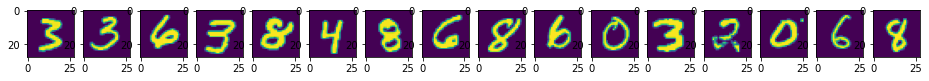

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(data[i])

In [ ]:
response = predictor.predict(np.expand_dims(data, axis=1))
print("Raw prediction result:")
print(response)

In [56]:
labeled_predictions = list(zip(range(10), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Labeled predictions: 
[(0, -783.938720703125), (1, -630.6112060546875), (2, -535.90625), (3, 0.0), (4, -1065.4293212890625), (5, -435.3193054199219), (6, -908.871826171875), (7, -824.3023681640625), (8, -447.55023193359375), (9, -817.137939453125)]

Most likely answer: (3, 0.0)


In [37]:
response[0]

array([-334.4543457 , -327.50762939, -491.3326416 ,  -61.40234375,
       -516.87231445,    0.        , -367.18353271, -433.59234619,
       -426.53149414, -383.14672852])

### Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it

In [13]:
sagemaker_session.delete_endpoint(
    endpoint_name = predictor.endpoint_name
)